In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1543534297095924302
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 10267551683546741159
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


In [3]:
import pandas as pd
import numpy as np

In [5]:
Country_code=["AUS", "BRA", "CAN", "CHN", "GBR", "IND", "JPN", "SGP", "USA"]
Manufacture = pd.ExcelFile('/cleaned/Manufacturing.xlsx')
Service = pd.ExcelFile("/cleaned/Service.xlsx")
Manufacture_df=[]
Service_df=[]
for x in Country_code:
    Manufacture_df.append(pd.read_excel(Manufacture, x).replace('\.+', np.nan, regex=True))
    Service_df.append(pd.read_excel(Service, x).replace('\.+', np.nan, regex=True))

###LSTM Model

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow import keras

In [7]:
Data_dic_m = pd.ExcelFile('/cleaned/Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('/cleaned/Service_filled.xlsx')

In [8]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [9]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [10]:
class MRobustScaler():
      """
      Scale features using statistics that are robust to outliers.
      """
      def __init__(self, q1=0.2, q2=0.8):
          self.q1 = q1
          self.q2 = q2

      def fit(self, df, eps):
          """
          Return quantile range and median of all features

          Set qrange be 1 if feature has very small range, otherwise calculate
          the quantile range with specified quantile
          """
          df = df.astype('float64') # convert object to float
          self.df_median = df.median() #pd median uses np.nanmedian
          df_q1 = df.quantile(self.q1)
          df_q2 = df.quantile(self.q2)
          qrange = np.array(df_q2 - df_q1) #Near constant features have a very small range
          if np.isscalar(qrange):
                if qrange < eps:
                      qrange = 1.0
          elif isinstance(qrange, np.ndarray):
                constant_mask = qrange < np.ones_like(qrange)*eps
                qrange[constant_mask] = 1.0
          self.qrange = qrange
          self.df_qrange = pd.Series(index = self.df_median.index, data=qrange)
          return self.qrange, self.df_median
      
      def get_fitted(self):
        return self.df_median, self.qrange

      def transform(self, df, eps = 0.1):
          qrange, df_median = self.fit(df, eps = eps)
          return (df - df_median)/qrange

In [11]:
def train_test_split(df, train_ratio = 0.7, val_ratio = 0.9, IW = 3):
  """
  By default: train:val:test = 0.7:0.2:0.1
  """
  n = len(df)
  train_df = df[0:int(n*train_ratio)]
  val_df = df[(int(n*train_ratio)-IW):int(n*val_ratio)]
  test_df = df[(int(n*val_ratio)-IW):]
  return train_df, val_df, test_df

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, scaled_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.scaled_data = scaled_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def all_data(self):
    return self.make_dataset(self.scaled_data)

In [13]:
def fetch_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.test)
  y_pred = np.array(y_pred)*qrange+target_median
  y_real = np.array([y*qrange+target_median for _, y in model.data_window.test]).reshape(y_pred.shape)
  return y_pred, y_real

In [14]:
def MAE(y_pred, y_real, verbose = 1):
  E = y_pred-y_real
  return np.mean(np.abs(E), axis = 0), np.mean(np.abs(E))

def MSE(y_pred, y_real):
  E = y_pred-y_real
  return np.mean(np.square(E), axis = 0), np.mean(np.square(E))

def RMSE(y_pred, y_real):
  np.sqrt(MSE(y_pred, y_real)[0])
  return np.sqrt(MSE(y_pred, y_real)[0]), np.sqrt(MSE(y_pred, y_real)[1])

In [15]:
def fetch_all_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.all_data)
  y_pred = np.array(y_pred)*qrange+target_median
  y = None
  for _, j in  model.data_window.all_data:
    if y is None:
      y = j*qrange+target_median
    else:
      y = np.concatenate((y, j*qrange+target_median))
  if type(y).__module__ != np.__name__:
    y = y.numpy()
  y_real = y.reshape(y_pred.shape)
  return y_pred, y_real

In [16]:
def pat_pred(y, data):
  """
  y could be y_real or y_pred
  """
  d = pd.DataFrame({})
  for i in range(y.shape[1]):
    d[f'gap_{i}'] =  [np.nan] * i + list(y[:, i]) + [np.nan] * (y.shape[1]-i-1)
  d.index = data[IW:].index
  return d

In [17]:
def forecast(rbscaler, scaled_data, model, name = 'Manufacturing_value added_%_of_GDP'):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y = model.model.predict(np.expand_dims(scaled_data.iloc[-3:, :], axis = 0))
  df =  pd.DataFrame({name: (np.array(y)*qrange+target_median).tolist()[0]}, index =  [scaled_data.index[-1]+i for i in range(1, 6)])
  return df

In [39]:
def pipeline(country = 'CHN', method = 'Median'):
  data = m_dfs[(country, method)]
  # drop all column 0
  data = data.dropna(axis=1, how='all')
  # drop nan row according to target
  data = data[data[data.columns[-1]].notna()]
  data = data.fillna(data.median())
  rbscaler = MRobustScaler()
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  val_loss=model.history.history['val_loss'][-1]
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
  )
  y_pred1, y_real1 = fetch_all_pred_real(rbscaler, model)
  ### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
  display(pd.concat([data.iloc[:, -1], pat_pred(y_pred1, data)], axis = 1).plot(figsize = (20, 4), title = dic_country[country] + ' (' +  method + ') :' \
                                                                         + '\nMean MAE: ' + str(MAE(y_pred, y_real)[1]) \
                                                                         + '\nMean MSE: ' + str(MSE(y_pred, y_real)[1]) \
                                                                         + '\nMean RMSE: ' + str(RMSE(y_pred, y_real)[1]) \
                                                                         ))
  display(forecast(rbscaler, scaled_data, model, name = country + '_' + method))
  return  MAE(y_pred, y_real)[1], MSE(y_pred, y_real)[1], RMSE(y_pred, y_real)[1],val_loss

In [18]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = False
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()


In [20]:
Data_dic_m = pd.ExcelFile('/cleaned/Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('/cleaned/Service_filled.xlsx')
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10+1):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    #n = len(df)
    #df = df[0:int(n*0.9)]
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10+1):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    #n = len(df)
    #df = df[0:int(n*0.9)]
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

# Tuning **hyperparamenters**

In [21]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [22]:
class LSTM_base:

  def __init__(self, lookback_width, num_features, loss=None, layer1=512, layer2=256, layer3=256, label_width=1):
    self.lookback_width = lookback_width
    self.num_features = num_features
    self.loss = loss 
    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.label_width = label_width
    self.create_model()
    self.history = None

  def create_model(self):
    input = layers.Input(shape=(self.lookback_width, self.num_features), name='input')
    x = layers.LSTM(self.layer1, return_sequences=True)(input)
    x = layers.Dropout(0.05)(x)
    x = layers.LSTM(self.layer2, return_sequences=True)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(self.layer3)(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(self.label_width)(x)
    model = keras.Model(input, outputs=output)
    self.model = model

  def compile_and_fit(self, data_window, epochs, batch_size, verbose, learning_rate, patience=4):
    loss=self.loss,
    history = History()
    batch_size = batch_size[0] if isinstance(batch_size, tuple) else batch_size
    self.model.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    self.history = self.model.fit(data_window.train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=data_window.val, 
                                  callbacks=[history, EarlyStopping(monitor='val_loss',
                                                           patience=patience,
                                                           mode='auto',
                                                           restore_best_weights=True)],
                                  verbose=verbose,
                                  shuffle=False)
    return self.history

  def plot(self):
    display(tf.keras.utils.plot_model(self.model, show_shapes=True))
  
  def train(self, data_window, MAX_EPOCHS, bs, verbose, lr, patience):
    start = time()
    self.data_window = data_window
    self.compile_and_fit(data_window=data_window,
                                epochs=MAX_EPOCHS,
                                batch_size=bs,
                                verbose=verbose,
                                learning_rate=lr,
                                patience=patience)
    delta=time()-start
    self.delta = delta
    print('Total Modelling Time: ',delta)

In [23]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = False
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

## Grid Search

In [ ]:
import itertools

lr = [0.1,0.01,0.001,0.0001]
bs = [10,25,32,64]
patience = [20,40,50,60]
MAX_EPOCHS = [50,75,100,120]
LOSS=tf.keras.losses.MeanAbsoluteError()

hyper_para = (lr, bs, patience, MAX_EPOCHS)
hyper_para_grid = tuple(itertools.product(*hyper_para, repeat=1))
print(len(hyper_para_grid))
for lr, bs, patience, MAX_EPOCHS in hyper_para_grid:
  print('lr',lr, 'Batch size', bs, 'patience', patience,'MAX_EPOCHS', MAX_EPOCHS)

256
lr 0.1 Batch size 10 patience 20 MAX_EPOCHS 50
lr 0.1 Batch size 10 patience 20 MAX_EPOCHS 75
lr 0.1 Batch size 10 patience 20 MAX_EPOCHS 100
lr 0.1 Batch size 10 patience 20 MAX_EPOCHS 120
lr 0.1 Batch size 10 patience 40 MAX_EPOCHS 50
lr 0.1 Batch size 10 patience 40 MAX_EPOCHS 75
lr 0.1 Batch size 10 patience 40 MAX_EPOCHS 100
lr 0.1 Batch size 10 patience 40 MAX_EPOCHS 120
lr 0.1 Batch size 10 patience 50 MAX_EPOCHS 50
lr 0.1 Batch size 10 patience 50 MAX_EPOCHS 75
lr 0.1 Batch size 10 patience 50 MAX_EPOCHS 100
lr 0.1 Batch size 10 patience 50 MAX_EPOCHS 120
lr 0.1 Batch size 10 patience 60 MAX_EPOCHS 50
lr 0.1 Batch size 10 patience 60 MAX_EPOCHS 75
lr 0.1 Batch size 10 patience 60 MAX_EPOCHS 100
lr 0.1 Batch size 10 patience 60 MAX_EPOCHS 120
lr 0.1 Batch size 25 patience 20 MAX_EPOCHS 50
lr 0.1 Batch size 25 patience 20 MAX_EPOCHS 75
lr 0.1 Batch size 25 patience 20 MAX_EPOCHS 100
lr 0.1 Batch size 25 patience 20 MAX_EPOCHS 120
lr 0.1 Batch size 25 patience 40 MAX_EPOCHS 50

## PIPELINE

In [32]:
int_value=0
country_valloss = \
{'AUS': int_value,
 'BRA': int_value,
 'CAN': int_value,
 'CHN': int_value,
 'GBR': int_value,
 'IND': int_value,
 'JPN': int_value,
 'SGP': int_value,
 'USA': int_value,}

In [31]:
Best_lr=[]
Best_bs=[]
Best_patience=[]
Best_max_epochs=[]
Mean_Val_lost=[]
Dataset=[]

In [26]:
def tuning_pipeline(hyper_parameter):
  min_val_loss_ser = 999
  min_val_loss_manu = 999
  best_params_ser = [0,0,0,0]
  for lr, bs, patience, MAX_EPOCHS in hyper_parameter[188:]:
    for dataset in range(2):
        for country in Country_code:
          method="optimized"
          if dataset == 0:
             data = m_dfs[(country, method)]
             datasett="Manufacturing"
          elif dataset == 1:
             data = s_dfs[(country, method)]
             datasett="Service"
  # drop all column 0
          data = data.dropna(axis=1, how='all')
  # drop nan row according to target
          data = data[data[data.columns[-1]].notna()]
          data = data.fillna(data.median())
          rbscaler = MRobustScaler()
          scaled_data = rbscaler.transform(data, 0.1)
          train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
          wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
          model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
          lstm_model=model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
          country_valloss[country] = model.history.history['val_loss'][-1]
        mean_val_loss=np.mean(list(country_valloss.values()))
        print(mean_val_loss)
        if dataset==1:
            if mean_val_loss < min_val_loss_ser:
               min_val_loss_ser = mean_val_loss
               best_params_ser = [lr, bs, patience, MAX_EPOCHS]
        elif dataset==0:
            if mean_val_loss < min_val_loss_manu:
               min_val_loss_manu = mean_val_loss
               best_params_manu = [lr, bs, patience, MAX_EPOCHS]
        Best_lr.append(lr)
        Best_bs.append(bs)
        Best_patience.append(patience)
        Best_max_epochs.append(MAX_EPOCHS)
        Mean_Val_lost.append(mean_val_loss)
        Dataset.append(datasett)
        print('best params manu',best_params_manu)
        print("bese params ser",best_params_ser)

In [ ]:
with tf.device('/CPU:0'):
    tuning_pipeline(hyper_para_grid)

In [ ]:
result=pd.DataFrame({
    'Learning rate': Best_lr,
    'Batch size': Best_bs,
    'patience': Best_patience,
    'max epoch': Best_max_epochs,
    "val loss": Mean_Val_lost,
    "Dataset" : Dataset
})

In [ ]:
result[result.Dataset=="Manufacturing"].sort_values("val loss")

,Learning rate,Batch size,patience,max epoch,val loss,Dataset
220,0.001,25,20,120,0.285038,Manufacturing
246,0.001,32,20,50,0.285288,Manufacturing
284,0.001,64,20,120,0.285417,Manufacturing
252,0.001,32,20,120,0.285682,Manufacturing
186,0.001,10,20,100,0.285982,Manufacturing
...,...,...,...,...,...,...
15,0.100,10,20,120,2.632188,Manufacturing
25,0.100,10,50,50,2.635321,Manufacturing
6,0.100,10,20,120,3.527617,Manufacturing
33,0.100,10,60,50,3.982348,Manufacturing


In [ ]:
result[result.Dataset=="Service"].sort_values("val loss")

,Learning rate,Batch size,patience,max epoch,val loss,Dataset
289,0.001,64,40,75,0.232308,Service
225,0.001,25,40,75,0.234421,Service
233,0.001,25,50,75,0.235997,Service
285,0.001,64,20,120,0.239067,Service
259,0.001,32,40,100,0.239570,Service
...,...,...,...,...,...,...
10,0.100,10,20,50,3.559767,Service
36,0.100,10,60,75,3.601878,Service
56,0.100,25,40,120,4.271204,Service
46,0.100,25,20,100,4.467491,Service


In [ ]:
result

,Learning rate,Batch size,patience,max epoch,val loss,Dataset
0,0.1000,10,20,50,2.293402,Manufacturing
1,0.1000,10,20,50,1.526766,Service
2,0.1000,10,20,75,2.139943,Manufacturing
3,0.1000,10,20,75,1.919137,Service
4,0.1000,10,20,100,1.206674,Manufacturing
...,...,...,...,...,...,...
370,0.0001,25,60,100,0.324478,Manufacturing
371,0.0001,25,60,100,0.295144,Service
372,0.0001,25,60,120,0.312996,Manufacturing
373,0.0001,25,60,120,0.285464,Service


## Random Search

In [27]:
def get_hyper_param(n_iteration):
  hyper_param = []  # ('lr',lr, 'Batch size', bs, 'patience', patience,'MAX_EPOCHS', MAX_EPOCHS)
  for i in range(n_iteration):
    current_params = []
    current_params.append(np.random.uniform(0.0005,0.0015))
    current_params.append(np.random.randint(25,64))
    current_params.append(np.random.randint(20,50))
    current_params.append(np.random.randint(40,80))
    hyper_param.append(current_params)
  return hyper_param
  
hyper_parameter_random = get_hyper_param(500)

In [ ]:
hyper_parameter_random

In [33]:
with tf.device('/CPU:0'):
    tuning_pipeline(hyper_parameter_random)

Streaming output truncated to the last 5000 lines.
Total Modelling Time:  4.3177268505096436
Total Modelling Time:  4.9002978801727295
Total Modelling Time:  4.823029041290283
Total Modelling Time:  5.147489786148071
Total Modelling Time:  3.6022160053253174
0.2450558278295729
best params manu [0.0005830958109285446, 43, 24, 55]
bese params ser [0.001282139438716566, 49, 23, 62]
Total Modelling Time:  6.137042045593262
Total Modelling Time:  5.48208212852478
Total Modelling Time:  5.342545032501221
Total Modelling Time:  5.877164125442505
Total Modelling Time:  6.085791826248169
Total Modelling Time:  5.159821033477783
Total Modelling Time:  4.933633089065552
Total Modelling Time:  5.264724969863892
Total Modelling Time:  6.01067590713501
0.3458344166477521
best params manu [0.0005830958109285446, 43, 24, 55]
bese params ser [0.001282139438716566, 49, 23, 62]
Total Modelling Time:  5.4339258670806885
Total Modelling Time:  5.182577133178711
Total Modelling Time:  5.9749040603637695
Tot

In [34]:
result_random=pd.DataFrame({
    'Learning rate': Best_lr,
    'Batch size': Best_bs,
    'patience': Best_patience,
    'max epoch': Best_max_epochs,
    "val loss": Mean_Val_lost,
    "Dataset" : Dataset
})

In [35]:
result_random[result_random.Dataset=="Manufacturing"].sort_values("val loss")

,Learning rate,Batch size,patience,max epoch,val loss,Dataset
566,0.000521,46,22,70,0.282639,Manufacturing
494,0.000787,25,24,77,0.283485,Manufacturing
58,0.000583,43,24,55,0.284099,Manufacturing
202,0.000810,57,23,47,0.284141,Manufacturing
340,0.000812,42,24,44,0.285560,Manufacturing
...,...,...,...,...,...,...
8,0.001274,54,44,63,0.351779,Manufacturing
434,0.001353,42,46,79,0.351818,Manufacturing
30,0.001432,48,41,73,0.354237,Manufacturing
138,0.001338,53,43,72,0.355089,Manufacturing


In [41]:
result_random[result_random.Dataset=="Service"].sort_values("val loss")

,Learning rate,Batch size,patience,max epoch,val loss,Dataset
151,0.001282,49,23,62,0.222287,Service
561,0.001412,39,25,56,0.222982,Service
115,0.001071,43,26,63,0.223079,Service
405,0.001159,31,24,65,0.223274,Service
35,0.000930,32,32,68,0.227273,Service
...,...,...,...,...,...,...
589,0.000873,26,35,43,0.262127,Service
209,0.001193,55,49,76,0.263013,Service
275,0.001398,31,48,78,0.263933,Service
107,0.001293,33,49,75,0.264805,Service


## Optimized performance

Australia default alpha :
Total Modelling Time:  7.639152765274048
1/1 [==============================] - 1s 642ms/step
MAE [1.6600031, 1.8705639, 1.3360426, 1.0221298, 0.8590229]  Mean MAE 1.3495525 
MSE [3.0549731, 3.7678623, 2.2452989, 1.5366281, 1.0874324]  Mean MSE 2.338439 
RMSE [1.7478482, 1.9410982, 1.4984322, 1.239608, 1.0428003] Mean RMSE 1.5291955
1/1 [==============================] - 0s 79ms/step


<AxesSubplot: title={'center': 'Australia (default alpha) :\nMean MAE: 1.3495525\nMean MSE: 2.338439\nMean RMSE: 1.5291955'}, xlabel='Year'>

1/1 [==============================] - 1s 643ms/step


,AUS_default alpha
2022,9.893109
2023,9.929046
2024,10.066659
2025,10.351357
2026,10.702355




Brazil default alpha :
Total Modelling Time:  8.206218004226685
1/1 [==============================] - 1s 863ms/step
MAE [5.383703, 0.78484184, 2.457385, 6.2874513, 9.648441]  Mean MAE 4.9123645 
MSE [29.147253, 0.6823058, 6.0745034, 39.800217, 93.894226]  Mean MSE 33.9197 
RMSE [5.3988194, 0.82601804, 2.4646509, 6.308741, 9.689903] Mean RMSE 5.8240623
2/2 [==============================] - 0s 80ms/step


<AxesSubplot: title={'center': 'Brazil (default alpha) :\nMean MAE: 4.9123645\nMean MSE: 33.9197\nMean RMSE: 5.8240623'}, xlabel='Year'>

1/1 [==============================] - 1s 880ms/step


,BRA_default alpha
2022,7.009553
2023,10.667768
2024,13.109753
2025,16.052738
2026,18.302698




India default alpha :
Total Modelling Time:  11.786404132843018
1/1 [==============================] - 1s 911ms/step
MAE [0.6297138, 0.2554927, 0.17262435, 0.42031527, 0.64498234]  Mean MAE 0.4246257 
MSE [0.4366917, 0.09852244, 0.03296706, 0.22212675, 0.5560622]  Mean MSE 0.26927406 
RMSE [0.6608265, 0.31388286, 0.18156834, 0.47130325, 0.74569577] Mean RMSE 0.51891625
1/1 [==============================] - 0s 120ms/step


<AxesSubplot: title={'center': 'India (default alpha) :\nMean MAE: 0.4246257\nMean MSE: 0.26927406\nMean RMSE: 0.51891625'}, xlabel='Year'>

1/1 [==============================] - 1s 765ms/step


,CAN_default alpha
2019,12.284304
2020,12.353062
2021,12.333280
2022,12.200704
2023,12.135828




China default alpha :
Total Modelling Time:  10.461053848266602
1/1 [==============================] - 1s 895ms/step
MAE [3.0178325, 3.3828404, 3.4086888, 3.6161556, 2.967474]  Mean MAE 3.278598 
MSE [9.237347, 11.452027, 11.939095, 13.575345, 8.92983]  Mean MSE 11.02673 
RMSE [3.0393004, 3.3840845, 3.4552994, 3.6844735, 2.988282] Mean RMSE 3.320652
1/1 [==============================] - 0s 130ms/step


<AxesSubplot: title={'center': 'China (default alpha) :\nMean MAE: 3.278598\nMean MSE: 11.02673\nMean RMSE: 3.320652'}, xlabel='Year'>

1/1 [==============================] - 1s 846ms/step


,CHN_default alpha
2022,31.202845
2023,31.152201
2024,31.163559
2025,31.785723
2026,32.683403




United Kingdom default alpha :
Total Modelling Time:  9.557576894760132
1/1 [==============================] - 1s 690ms/step
MAE [0.4106966, 0.3747204, 0.33597374, 0.40263575, 0.5755247]  Mean MAE 0.41991025 
MSE [0.24951673, 0.20679168, 0.14578351, 0.22538492, 0.3724039]  Mean MSE 0.23997615 
RMSE [0.4995165, 0.45474353, 0.38181606, 0.4747472, 0.61024904] Mean RMSE 0.48987362
1/1 [==============================] - 0s 131ms/step


<AxesSubplot: title={'center': 'United Kingdom (default alpha) :\nMean MAE: 0.41991025\nMean MSE: 0.23997615\nMean RMSE: 0.48987362'}, xlabel='Year'>

1/1 [==============================] - 1s 689ms/step


,GBR_default alpha
2022,10.544457
2023,10.211973
2024,10.008440
2025,9.876885
2026,9.774405




India default alpha :
Total Modelling Time:  8.044319868087769
1/1 [==============================] - 1s 690ms/step
MAE [0.57804567, 0.19675827, 0.6828672, 1.0986177, 1.8575886]  Mean MAE 0.8827755 
MSE [0.40305564, 0.073435955, 0.8881374, 1.9482418, 4.4049196]  Mean MSE 1.5435582 
RMSE [0.63486665, 0.2709907, 0.9424104, 1.3957944, 2.09879] Mean RMSE 1.2424002
2/2 [==============================] - 0s 79ms/step


<AxesSubplot: title={'center': 'India (default alpha) :\nMean MAE: 0.8827755\nMean MSE: 1.5435582\nMean RMSE: 1.2424002'}, xlabel='Year'>

1/1 [==============================] - 1s 716ms/step


,IND_default alpha
2022,14.673328
2023,14.992305
2024,15.666324
2025,16.071539
2026,17.230225




Japan default alpha :
Total Modelling Time:  8.270076751708984
1/1 [==============================] - 1s 758ms/step
MAE [2.6111336, 2.0348377, 1.3719244, 0.5372262, 0.49633837]  Mean MAE 1.410292 
MSE [7.784974, 4.4862375, 2.0514915, 0.34457195, 0.3232249]  Mean MSE 2.9981 
RMSE [2.7901566, 2.118074, 1.4323028, 0.5870025, 0.5685287] Mean RMSE 1.7315023
1/1 [==============================] - 0s 124ms/step


<AxesSubplot: title={'center': 'Japan (default alpha) :\nMean MAE: 1.410292\nMean MSE: 2.9981\nMean RMSE: 1.7315023'}, xlabel='Year'>

1/1 [==============================] - 1s 692ms/step


,JPN_default alpha
2021,19.692513
2022,20.357555
2023,21.129915
2024,21.532480
2025,21.554392




Singapore default alpha :
Total Modelling Time:  8.196516036987305
1/1 [==============================] - 1s 1s/step
MAE [5.4180617, 6.7625356, 7.7114015, 6.4316993, 6.1856766]  Mean MAE 6.5018744 
MSE [29.608149, 47.095997, 60.38104, 42.30749, 39.05308]  Mean MSE 43.68915 
RMSE [5.441337, 6.8626523, 7.7705235, 6.5044208, 6.2492466] Mean RMSE 6.609777
2/2 [==============================] - 0s 78ms/step


<AxesSubplot: title={'center': 'Singapore (default alpha) :\nMean MAE: 6.5018744\nMean MSE: 43.68915\nMean RMSE: 6.609777'}, xlabel='Year'>

1/1 [==============================] - 1s 694ms/step


,SGP_default alpha
2022,20.485683
2023,22.060328
2024,24.052355
2025,24.953962
2026,26.902283




United States default alpha :
Total Modelling Time:  8.172101974487305
1/1 [==============================] - 1s 748ms/step
MAE [0.46444225, 0.39523983, 0.42721987, 0.6434312, 0.72817993]  Mean MAE 0.53170264 
MSE [0.26017728, 0.20825186, 0.22024485, 0.43384123, 0.5433512]  Mean MSE 0.33317327 
RMSE [0.51007575, 0.4563462, 0.4693025, 0.65866625, 0.7371236] Mean RMSE 0.5772116
1/1 [==============================] - 0s 148ms/step


<AxesSubplot: title={'center': 'United States (default alpha) :\nMean MAE: 0.53170264\nMean MSE: 0.33317327\nMean RMSE: 0.5772116'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,USA_default alpha
2021,11.793000
2022,11.949794
2023,12.182039
2024,12.187003
2025,12.135027




Australia optimized :
Total Modelling Time:  9.764531135559082
1/1 [==============================] - 1s 774ms/step
MAE [0.40543634, 0.78312, 0.37060204, 0.733281, 0.23680314]  Mean MAE 0.5058485 
MSE [0.23269275, 0.67459977, 0.2103409, 0.59204304, 0.102536894]  Mean MSE 0.36244267 
RMSE [0.48238236, 0.8213402, 0.45862937, 0.76944333, 0.32021382] Mean RMSE 0.6020321
1/1 [==============================] - 0s 118ms/step


<AxesSubplot: title={'center': 'Australia (optimized) :\nMean MAE: 0.5058485\nMean MSE: 0.36244267\nMean RMSE: 0.6020321'}, xlabel='Year'>

1/1 [==============================] - 1s 735ms/step


,AUS_optimized
2022,7.807676
2023,7.904233
2024,7.658876
2025,7.969583
2026,7.801545




Brazil optimized :
Total Modelling Time:  8.812166690826416
1/1 [==============================] - 1s 771ms/step
MAE [0.82224846, 1.2850132, 1.051751, 0.29298767, 0.7783181]  Mean MAE 0.8460637 
MSE [1.0840826, 2.454191, 1.4396516, 0.12444368, 0.63397604]  Mean MSE 1.1472689 
RMSE [1.0411929, 1.5665858, 1.1998549, 0.35276577, 0.79622614] Mean RMSE 1.0711064
2/2 [==============================] - 0s 83ms/step


<AxesSubplot: title={'center': 'Brazil (optimized) :\nMean MAE: 0.8460637\nMean MSE: 1.1472689\nMean RMSE: 1.0711064'}, xlabel='Year'>

1/1 [==============================] - 1s 664ms/step


,BRA_optimized
2022,8.279560
2023,7.455098
2024,7.938302
2025,9.272565
2026,10.226539




India optimized :
Total Modelling Time:  11.737274169921875
1/1 [==============================] - 1s 1s/step
MAE [0.92744374, 0.70964026, 0.52829385, 0.62086177, 0.6481192]  Mean MAE 0.68687177 
MSE [0.90684366, 0.545128, 0.29663983, 0.48717868, 0.5726008]  Mean MSE 0.5616782 
RMSE [0.9522834, 0.73832786, 0.5446465, 0.6979819, 0.7567039] Mean RMSE 0.74945194
1/1 [==============================] - 0s 159ms/step


<AxesSubplot: title={'center': 'India (optimized) :\nMean MAE: 0.68687177\nMean MSE: 0.5616782\nMean RMSE: 0.74945194'}, xlabel='Year'>

1/1 [==============================] - 1s 929ms/step


,CAN_optimized
2019,11.697187
2020,12.068919
2021,12.358672
2022,12.511580
2023,12.473528




China optimized :
Total Modelling Time:  13.893907070159912
1/1 [==============================] - 2s 2s/step
MAE [2.8574505, 3.173278, 3.361581, 3.735611, 3.3762302]  Mean MAE 3.3008301 
MSE [8.288297, 10.076122, 11.594238, 14.378258, 11.577521]  Mean MSE 11.182888 
RMSE [2.87894, 3.174291, 3.4050312, 3.7918673, 3.4025757] Mean RMSE 3.3440826
1/1 [==============================] - 0s 142ms/step


<AxesSubplot: title={'center': 'China (optimized) :\nMean MAE: 3.3008301\nMean MSE: 11.182888\nMean RMSE: 3.3440826'}, xlabel='Year'>

1/1 [==============================] - 1s 884ms/step


,CHN_optimized
2022,30.912096
2023,30.854551
2024,30.858799
2025,31.001045
2026,31.264164




United Kingdom optimized :
Total Modelling Time:  13.409399032592773
1/1 [==============================] - 1s 847ms/step
MAE [0.26737005, 0.3343258, 0.42769566, 0.6949671, 0.75411]  Mean MAE 0.4956937 
MSE [0.09965082, 0.1470058, 0.22997811, 0.50971174, 0.5932184]  Mean MSE 0.31591296 
RMSE [0.3156752, 0.38341334, 0.47956035, 0.713941, 0.7702067] Mean RMSE 0.56206137
1/1 [==============================] - 0s 103ms/step


<AxesSubplot: title={'center': 'United Kingdom (optimized) :\nMean MAE: 0.4956937\nMean MSE: 0.31591296\nMean RMSE: 0.56206137'}, xlabel='Year'>

1/1 [==============================] - 1s 849ms/step


,GBR_optimized
2022,9.072872
2023,9.038345
2024,9.072567
2025,9.246728
2026,9.188544




India optimized :
Total Modelling Time:  9.488051891326904
1/1 [==============================] - 1s 858ms/step
MAE [0.4243884, 0.5076375, 0.8919346, 1.230452, 1.5732108]  Mean MAE 0.9255246 
MSE [0.24109556, 0.29575732, 1.1856258, 2.0930853, 2.9263384]  Mean MSE 1.3483804 
RMSE [0.49101484, 0.54383576, 1.0888644, 1.4467499, 1.7106544] Mean RMSE 1.1611979
2/2 [==============================] - 0s 110ms/step


<AxesSubplot: title={'center': 'India (optimized) :\nMean MAE: 0.9255246\nMean MSE: 1.3483804\nMean RMSE: 1.1611979'}, xlabel='Year'>

1/1 [==============================] - 1s 850ms/step


,IND_optimized
2022,15.423705
2023,15.388522
2024,15.558043
2025,15.769868
2026,15.949123




Japan optimized :
Total Modelling Time:  8.805907964706421
1/1 [==============================] - 1s 896ms/step
MAE [0.993073, 0.7251191, 0.46358156, 0.5634055, 0.69402695]  Mean MAE 0.68784124 
MSE [1.2093773, 0.6525407, 0.22899275, 0.3591692, 0.594948]  Mean MSE 0.6090056 
RMSE [1.0997169, 0.8077999, 0.47853187, 0.59930724, 0.77132875] Mean RMSE 0.7803881
1/1 [==============================] - 0s 179ms/step


<AxesSubplot: title={'center': 'Japan (optimized) :\nMean MAE: 0.68784124\nMean MSE: 0.6090056\nMean RMSE: 0.7803881'}, xlabel='Year'>

1/1 [==============================] - 1s 827ms/step


,JPN_optimized
2021,20.892908
2022,20.915100
2023,20.894955
2024,20.899202
2025,20.915150




Singapore optimized :
Total Modelling Time:  10.098617792129517
1/1 [==============================] - 1s 840ms/step
MAE [4.0275664, 3.5903015, 3.2065408, 2.8268301, 2.1587832]  Mean MAE 3.1620047 
MSE [16.498497, 14.411903, 11.831337, 9.65053, 6.749624]  Mean MSE 11.82838 
RMSE [4.0618343, 3.7963014, 3.439671, 3.1065302, 2.5980039] Mean RMSE 3.4392412
2/2 [==============================] - 0s 90ms/step


<AxesSubplot: title={'center': 'Singapore (optimized) :\nMean MAE: 3.1620047\nMean MSE: 11.82838\nMean RMSE: 3.4392412'}, xlabel='Year'>

1/1 [==============================] - 1s 806ms/step


,SGP_optimized
2022,21.749615
2023,21.380255
2024,21.123026
2025,20.976864
2026,20.738411




United States optimized :
Total Modelling Time:  10.073281049728394
1/1 [==============================] - 1s 1s/step
MAE [0.49240065, 0.62593126, 0.71194506, 0.8431742, 0.8557527]  Mean MAE 0.70584077 
MSE [0.28771448, 0.43468404, 0.5367708, 0.720199, 0.74165446]  Mean MSE 0.5442046 
RMSE [0.53639024, 0.65930575, 0.73264647, 0.8486454, 0.8611936] Mean RMSE 0.73770225
1/1 [==============================] - 0s 165ms/step


<AxesSubplot: title={'center': 'United States (optimized) :\nMean MAE: 0.70584077\nMean MSE: 0.5442046\nMean RMSE: 0.73770225'}, xlabel='Year'>

1/1 [==============================] - 1s 958ms/step


,USA_optimized
2021,12.062749
2022,12.054309
2023,12.080781
2024,12.043774
2025,12.047616




Australia default alpha :
Total Modelling Time:  10.823109865188599
1/1 [==============================] - 1s 853ms/step
MAE [1.4115875, 1.8167623, 1.2968425, 0.8113537, 0.70920324]  Mean MAE 1.2091498 
MSE [2.201629, 3.5337214, 2.0280192, 0.9869791, 0.6742368]  Mean MSE 1.8849171 
RMSE [1.4837887, 1.8798195, 1.4240854, 0.9934682, 0.82111925] Mean RMSE 1.3729229
1/1 [==============================] - 0s 167ms/step


<AxesSubplot: title={'center': 'Australia (default alpha) :\nMean MAE: 1.2091498\nMean MSE: 1.8849171\nMean RMSE: 1.3729229'}, xlabel='Year'>

1/1 [==============================] - 1s 743ms/step


,AUS_default alpha
2022,9.269848
2023,9.684112
2024,9.692850
2025,9.922275
2026,9.998113




Brazil default alpha :
Total Modelling Time:  9.121920108795166
1/1 [==============================] - 1s 858ms/step
MAE [5.9511914, 2.7363453, 1.12915, 6.04628, 10.041446]  Mean MAE 5.180882 
MSE [35.683743, 7.663831, 1.3866409, 36.865158, 101.81234]  Mean MSE 36.682346 
RMSE [5.973587, 2.7683625, 1.1775572, 6.0716686, 10.09021] Mean RMSE 6.0565953
2/2 [==============================] - 0s 109ms/step


<AxesSubplot: title={'center': 'Brazil (default alpha) :\nMean MAE: 5.180882\nMean MSE: 36.682346\nMean RMSE: 6.0565953'}, xlabel='Year'>

1/1 [==============================] - 1s 839ms/step


,BRA_default alpha
2022,6.746122
2023,9.202051
2024,10.108191
2025,15.349268
2026,18.021889




India default alpha :
Total Modelling Time:  9.255697250366211
1/1 [==============================] - 1s 940ms/step
MAE [0.6228318, 0.3682003, 0.13527608, 0.5121639, 0.62469435]  Mean MAE 0.4526333 
MSE [0.42697066, 0.18355514, 0.0294498, 0.3821329, 0.5597105]  Mean MSE 0.3163638 
RMSE [0.6534299, 0.42843336, 0.17160945, 0.618169, 0.748138] Mean RMSE 0.5624623
1/1 [==============================] - 0s 168ms/step


/Users/freddy/opt/miniconda3/envs/tensorflow_silicon/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot: title={'center': 'India (default alpha) :\nMean MAE: 0.4526333\nMean MSE: 0.3163638\nMean RMSE: 0.5624623'}, xlabel='Year'>

1/1 [==============================] - 1s 738ms/step


,CAN_default alpha
2019,12.324517
2020,12.252420
2021,12.596159
2022,12.378173
2023,12.403303




China default alpha :
Total Modelling Time:  12.594088077545166
1/1 [==============================] - 1s 1s/step
MAE [3.0006688, 3.4753425, 3.4153736, 3.6073525, 3.022824]  Mean MAE 3.3043122 
MSE [9.151478, 12.0849, 11.998597, 13.522664, 9.26226]  Mean MSE 11.20398 
RMSE [3.025141, 3.4763343, 3.4638991, 3.6773176, 3.0433962] Mean RMSE 3.3472347
1/1 [==============================] - 0s 198ms/step


<AxesSubplot: title={'center': 'China (default alpha) :\nMean MAE: 3.3043122\nMean MSE: 11.20398\nMean RMSE: 3.3472347'}, xlabel='Year'>

1/1 [==============================] - 1s 974ms/step


,CHN_default alpha
2022,31.532391
2023,31.060118
2024,31.260384
2025,31.863445
2026,32.773232




United Kingdom default alpha :
Total Modelling Time:  13.437630891799927
1/1 [==============================] - 1s 1s/step
MAE [0.4411537, 0.36404306, 0.30795747, 0.43620148, 0.53840446]  Mean MAE 0.41755202 
MSE [0.28174976, 0.19353092, 0.120225355, 0.2466645, 0.33510876]  Mean MSE 0.23545586 
RMSE [0.53080106, 0.4399215, 0.34673527, 0.4966533, 0.5788858] Mean RMSE 0.48523793
1/1 [==============================] - 0s 192ms/step


<AxesSubplot: title={'center': 'United Kingdom (default alpha) :\nMean MAE: 0.41755202\nMean MSE: 0.23545586\nMean RMSE: 0.48523793'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,GBR_default alpha
2022,10.325171
2023,10.089686
2024,9.813484
2025,9.778437
2026,9.710819




India default alpha :
Total Modelling Time:  14.594242811203003
1/1 [==============================] - 1s 1s/step
MAE [0.5299525, 0.23216534, 0.6744731, 1.2859488, 2.3169973]  Mean MAE 1.0079074 
MSE [0.3416219, 0.09623102, 0.8920471, 2.5044286, 6.4274745]  Mean MSE 2.0523605 
RMSE [0.5844843, 0.31021124, 0.94448245, 1.5825387, 2.5352464] Mean RMSE 1.4326062
2/2 [==============================] - 0s 136ms/step


<AxesSubplot: title={'center': 'India (default alpha) :\nMean MAE: 1.0079074\nMean MSE: 2.0523605\nMean RMSE: 1.4326062'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,IND_default alpha
2022,14.555311
2023,14.776430
2024,15.701422
2025,16.354588
2026,17.810469




Japan default alpha :
Total Modelling Time:  11.333534002304077
1/1 [==============================] - 1s 899ms/step
MAE [2.6687436, 2.202169, 1.3134451, 0.5487814, 0.6838875]  Mean MAE 1.4834054 
MSE [8.175987, 5.3585725, 1.9159646, 0.34183854, 0.5822779]  Mean MSE 3.2749279 
RMSE [2.8593683, 2.3148592, 1.3841838, 0.5846696, 0.76307136] Mean RMSE 1.8096762
1/1 [==============================] - 0s 121ms/step


<AxesSubplot: title={'center': 'Japan (default alpha) :\nMean MAE: 1.4834054\nMean MSE: 3.2749279\nMean RMSE: 1.8096762'}, xlabel='Year'>

1/1 [==============================] - 1s 849ms/step


,JPN_default alpha
2021,19.710567
2022,20.454889
2023,21.074284
2024,21.228117
2025,21.505377




Singapore default alpha :
Total Modelling Time:  10.528718948364258
1/1 [==============================] - 1s 819ms/step
MAE [4.4821663, 5.7352905, 7.3875732, 6.7856917, 6.288891]  Mean MAE 6.1359224 
MSE [20.430162, 34.55163, 55.5983, 46.810383, 40.317825]  Mean MSE 39.541668 
RMSE [4.5199738, 5.878063, 7.4564266, 6.841811, 6.349632] Mean RMSE 6.2882166
2/2 [==============================] - 0s 137ms/step


<AxesSubplot: title={'center': 'Singapore (default alpha) :\nMean MAE: 6.1359224\nMean MSE: 39.541668\nMean RMSE: 6.2882166'}, xlabel='Year'>

1/1 [==============================] - 1s 928ms/step


,SGP_default alpha
2022,19.561708
2023,20.944681
2024,23.490253
2025,25.596268
2026,26.884371




United States default alpha :
Total Modelling Time:  11.15718412399292
1/1 [==============================] - 1s 942ms/step
MAE [0.4036286, 0.38454127, 0.47737026, 0.7016208, 0.6998122]  Mean MAE 0.53339463 
MSE [0.20138972, 0.19253989, 0.25941473, 0.5103632, 0.50086963]  Mean MSE 0.33291546 
RMSE [0.44876465, 0.43879366, 0.5093277, 0.71439713, 0.7077214] Mean RMSE 0.5769883
1/1 [==============================] - 0s 174ms/step


<AxesSubplot: title={'center': 'United States (default alpha) :\nMean MAE: 0.53339463\nMean MSE: 0.33291546\nMean RMSE: 0.5769883'}, xlabel='Year'>

1/1 [==============================] - 1s 871ms/step


,USA_default alpha
2021,11.737448
2022,11.869740
2023,12.081633
2024,12.155376
2025,12.130852




Australia optimized :
Total Modelling Time:  11.152141809463501
1/1 [==============================] - 1s 987ms/step
MAE [0.4367014, 0.6637043, 0.3542406, 0.7466852, 0.87537277]  Mean MAE 0.6153408 
MSE [0.27178842, 0.50955564, 0.18732862, 0.60010946, 0.80040216]  Mean MSE 0.4738368 
RMSE [0.52133334, 0.71383166, 0.43281478, 0.7746673, 0.894652] Mean RMSE 0.68835807
1/1 [==============================] - 0s 164ms/step


<AxesSubplot: title={'center': 'Australia (optimized) :\nMean MAE: 0.6153408\nMean MSE: 0.4738368\nMean RMSE: 0.68835807'}, xlabel='Year'>

1/1 [==============================] - 2s 2s/step


,AUS_optimized
2022,8.032217
2023,7.964052
2024,7.558345
2025,6.944319
2026,6.703329




Brazil optimized :
Total Modelling Time:  9.919125080108643
1/1 [==============================] - 1s 1s/step
MAE [1.0385805, 0.810034, 1.30539, 0.64465046, 0.17659824]  Mean MAE 0.7950507 
MSE [1.6526095, 0.9436944, 2.1697528, 0.5299399, 0.043737236]  Mean MSE 1.0679467 
RMSE [1.2855386, 0.97143936, 1.473008, 0.7279697, 0.20913449] Mean RMSE 1.0334151
2/2 [==============================] - 0s 131ms/step


<AxesSubplot: title={'center': 'Brazil (optimized) :\nMean MAE: 0.7950507\nMean MSE: 1.0679467\nMean RMSE: 1.0334151'}, xlabel='Year'>

1/1 [==============================] - 1s 959ms/step


,BRA_optimized
2022,7.995327
2023,8.516762
2024,7.726123
2025,8.593613
2026,9.194325




India optimized :
Total Modelling Time:  11.234199047088623
1/1 [==============================] - 1s 965ms/step
MAE [0.8430126, 0.583652, 0.46488118, 0.4476943, 0.49044824]  Mean MAE 0.56593764 
MSE [0.8087925, 0.40930223, 0.23945326, 0.31412446, 0.37416285]  Mean MSE 0.42916703 
RMSE [0.8993289, 0.63976735, 0.48933962, 0.5604681, 0.61168855] Mean RMSE 0.6551084
1/1 [==============================] - 0s 176ms/step


<AxesSubplot: title={'center': 'India (optimized) :\nMean MAE: 0.56593764\nMean MSE: 0.42916703\nMean RMSE: 0.6551084'}, xlabel='Year'>

1/1 [==============================] - 1s 879ms/step


,CAN_optimized
2019,12.299812
2020,12.562696
2021,12.844418
2022,12.718889
2023,12.270138




China optimized :
Total Modelling Time:  12.12860894203186
1/1 [==============================] - 1s 1s/step
MAE [3.0557594, 3.2429268, 3.25008, 3.653951, 2.9141376]  Mean MAE 3.223371 
MSE [9.460687, 10.523244, 10.841293, 13.745742, 8.688165]  Mean MSE 10.651826 
RMSE [3.0758228, 3.243955, 3.2926118, 3.707525, 2.9475694] Mean RMSE 3.2637136
1/1 [==============================] - 0s 206ms/step


<AxesSubplot: title={'center': 'China (optimized) :\nMean MAE: 3.223371\nMean MSE: 10.651826\nMean RMSE: 3.2637136'}, xlabel='Year'>

1/1 [==============================] - 1s 943ms/step


,CHN_optimized
2022,30.954353
2023,30.901400
2024,30.716064
2025,30.825888
2026,30.806177




United Kingdom optimized :
Total Modelling Time:  18.94771385192871
1/1 [==============================] - 2s 2s/step
MAE [0.3094431, 0.43430424, 0.5372141, 0.61957586, 0.58926755]  Mean MAE 0.49796095 
MSE [0.12566915, 0.24111697, 0.32192725, 0.4040254, 0.36615634]  Mean MSE 0.291779 
RMSE [0.35449845, 0.49103662, 0.5673863, 0.63562995, 0.60510856] Mean RMSE 0.5401657
1/1 [==============================] - 0s 195ms/step


<AxesSubplot: title={'center': 'United Kingdom (optimized) :\nMean MAE: 0.49796095\nMean MSE: 0.291779\nMean RMSE: 0.5401657'}, xlabel='Year'>

1/1 [==============================] - 2s 2s/step


,GBR_optimized
2022,9.131174
2023,9.143314
2024,9.100438
2025,9.057293
2026,8.970196




India optimized :
Total Modelling Time:  15.22937822341919
1/1 [==============================] - 1s 1s/step
MAE [0.5416641, 0.65179986, 1.0475305, 1.3164665, 1.652576]  Mean MAE 1.0420073 
MSE [0.3582408, 0.46570325, 1.5107136, 2.321949, 3.1905267]  Mean MSE 1.5694267 
RMSE [0.5985322, 0.68242455, 1.2291108, 1.5237943, 1.7862046] Mean RMSE 1.2527676
2/2 [==============================] - 0s 192ms/step


<AxesSubplot: title={'center': 'India (optimized) :\nMean MAE: 1.0420073\nMean MSE: 1.5694267\nMean RMSE: 1.2527676'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,IND_optimized
2022,15.608498
2023,15.618210
2024,15.820317
2025,15.891982
2026,16.072628




Japan optimized :
Total Modelling Time:  16.001030921936035
1/1 [==============================] - 1s 1s/step
MAE [0.99416304, 0.7138324, 0.4607606, 0.5628419, 0.6949692]  Mean MAE 0.6853134 
MSE [1.2140692, 0.63602924, 0.22688669, 0.35840064, 0.59573483]  Mean MSE 0.60622406 
RMSE [1.1018481, 0.79751444, 0.47632626, 0.5986657, 0.7718386] Mean RMSE 0.7786039
1/1 [==============================] - 0s 279ms/step


<AxesSubplot: title={'center': 'Japan (optimized) :\nMean MAE: 0.6853134\nMean MSE: 0.60622406\nMean RMSE: 0.7786039'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,JPN_optimized
2021,20.857922
2022,20.858036
2023,20.874361
2024,20.879421
2025,20.890440




Singapore optimized :
Total Modelling Time:  14.783187866210938
1/1 [==============================] - 2s 2s/step
MAE [3.9496672, 3.272872, 3.106375, 2.696006, 2.0222137]  Mean MAE 3.0094266 
MSE [15.877093, 12.3756, 11.227672, 8.981236, 6.2378902]  Mean MSE 10.939899 
RMSE [3.984607, 3.5178971, 3.350772, 2.996871, 2.497577] Mean RMSE 3.3075519
2/2 [==============================] - 1s 163ms/step


<AxesSubplot: title={'center': 'Singapore (optimized) :\nMean MAE: 3.0094266\nMean MSE: 10.939899\nMean RMSE: 3.3075519'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,SGP_optimized
2022,21.651180
2023,20.873289
2024,21.066648
2025,20.888523
2026,20.629965




United States optimized :
Total Modelling Time:  18.67172408103943
1/1 [==============================] - 2s 2s/step
MAE [0.122205496, 0.15434861, 0.22774577, 0.5945301, 0.5549996]  Mean MAE 0.3307659 
MSE [0.0274554, 0.026190672, 0.06894136, 0.36418086, 0.31778353]  Mean MSE 0.16091035 
RMSE [0.16569671, 0.16183533, 0.26256686, 0.603474, 0.5637229] Mean RMSE 0.40113634
1/1 [==============================] - 0s 257ms/step


<AxesSubplot: title={'center': 'United States (optimized) :\nMean MAE: 0.3307659\nMean MSE: 0.16091035\nMean RMSE: 0.40113634'}, xlabel='Year'>

1/1 [==============================] - 1s 1s/step


,USA_optimized
2021,11.515938
2022,11.617050
2023,11.857918
2024,11.995667
2025,11.913910


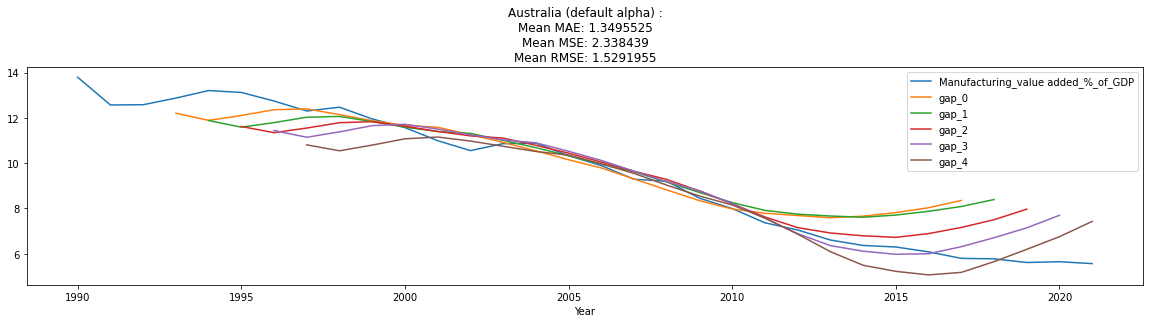

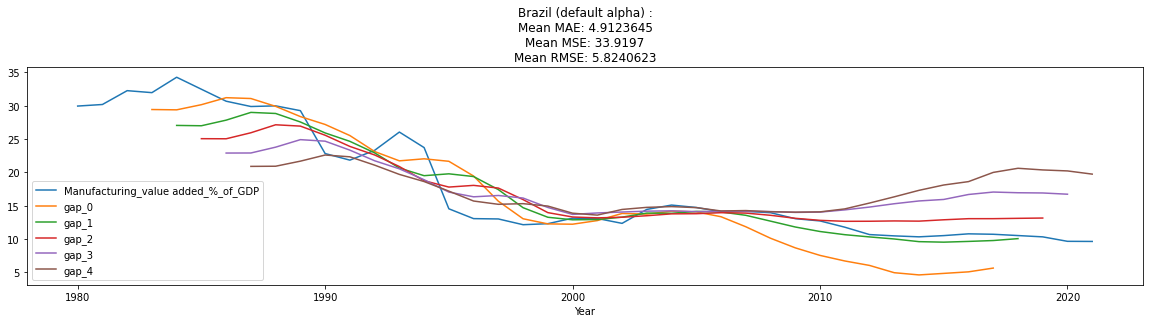

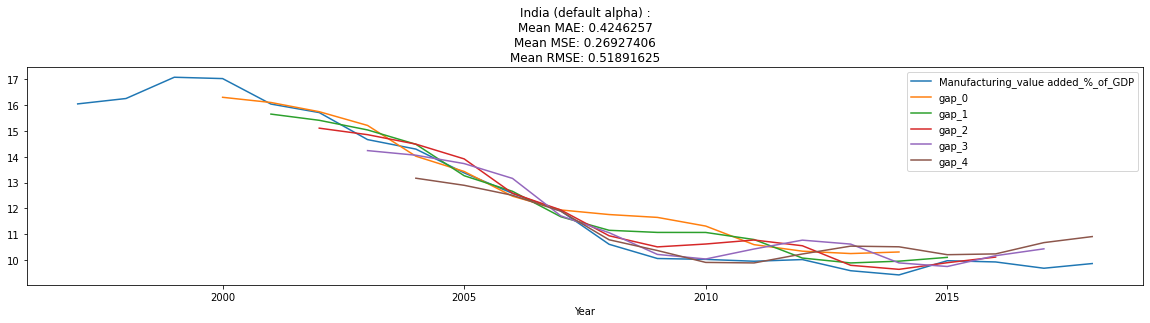

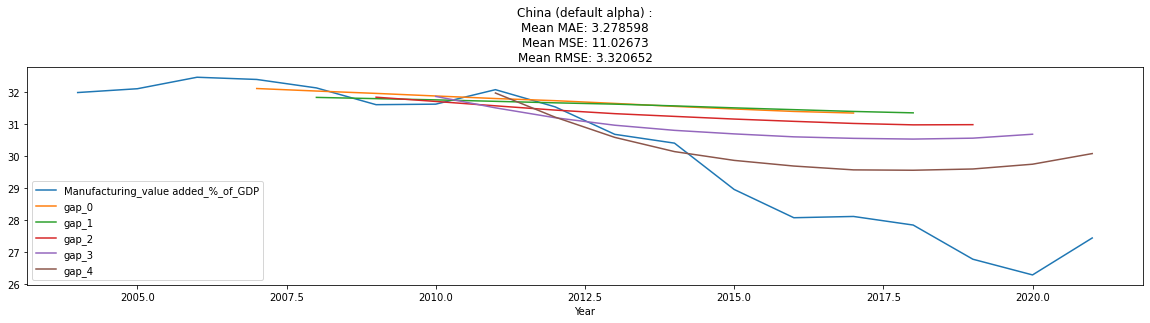

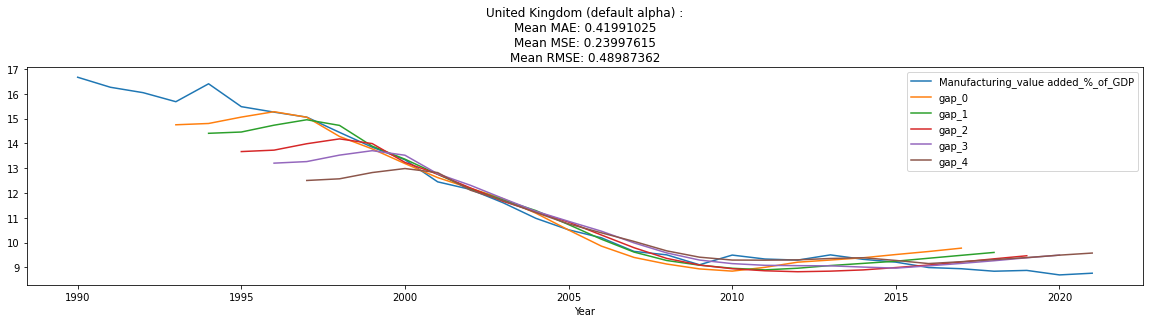

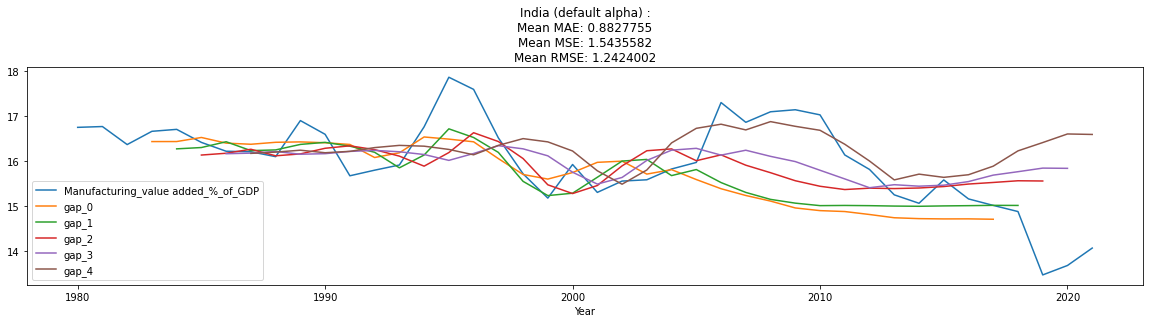

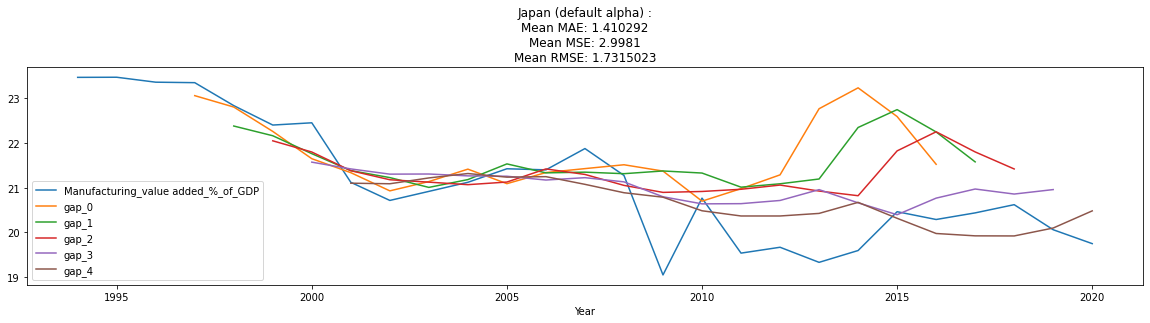

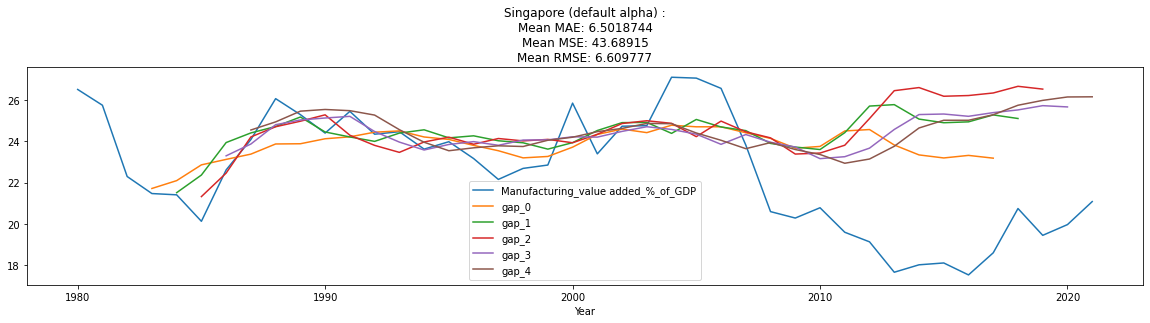

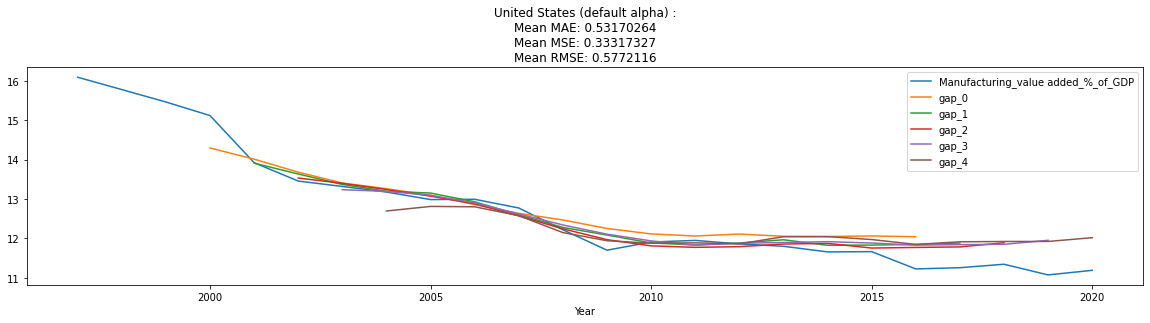

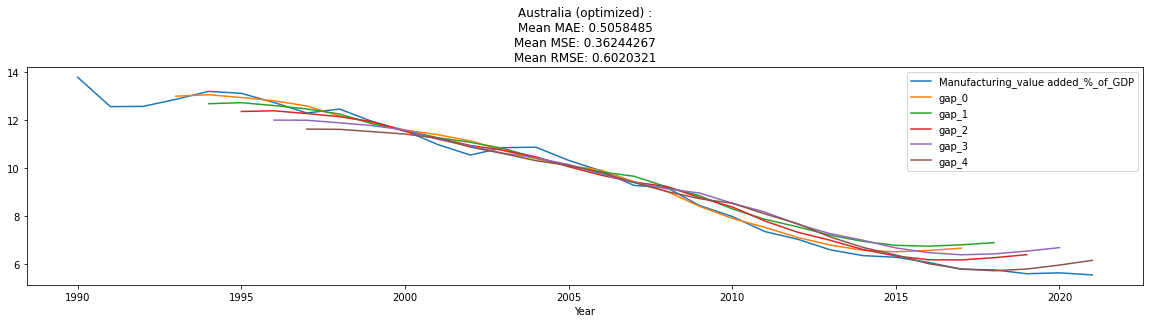

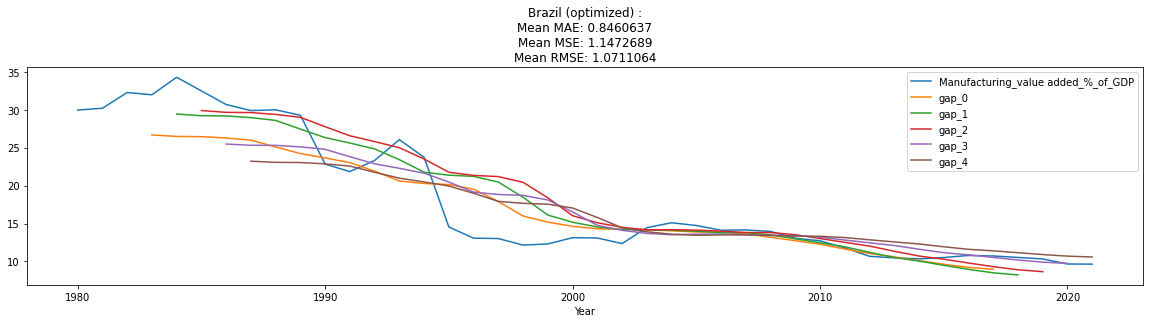

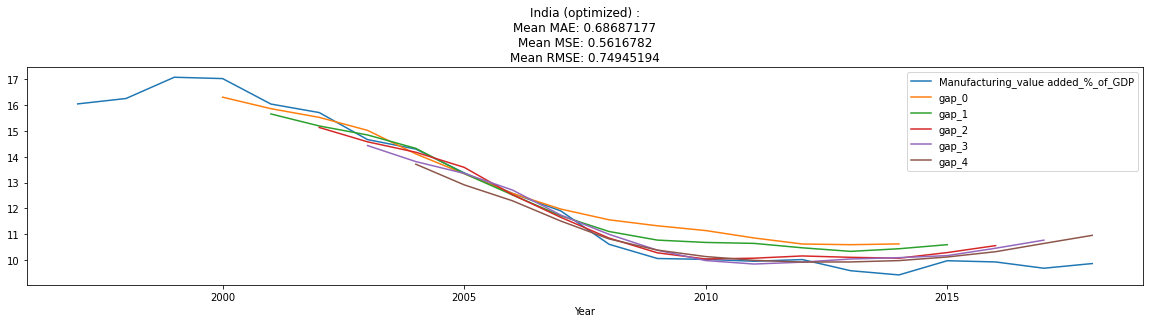

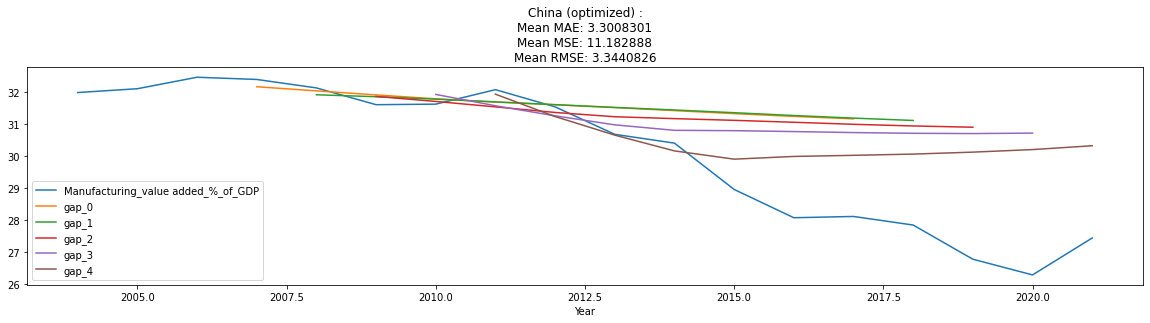

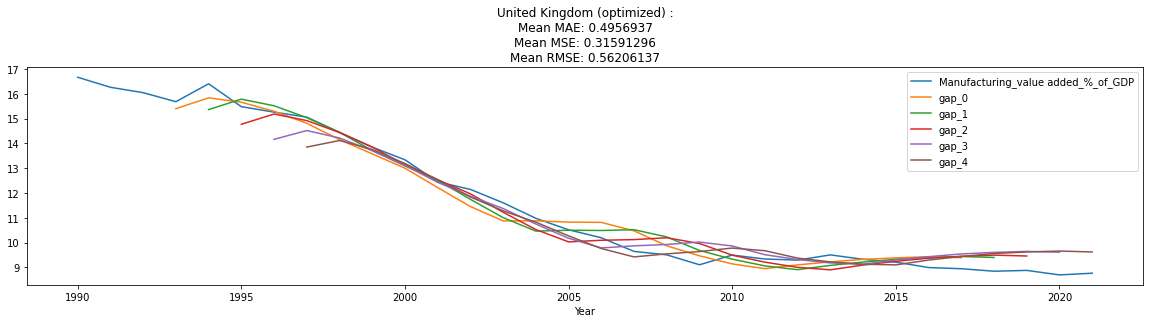

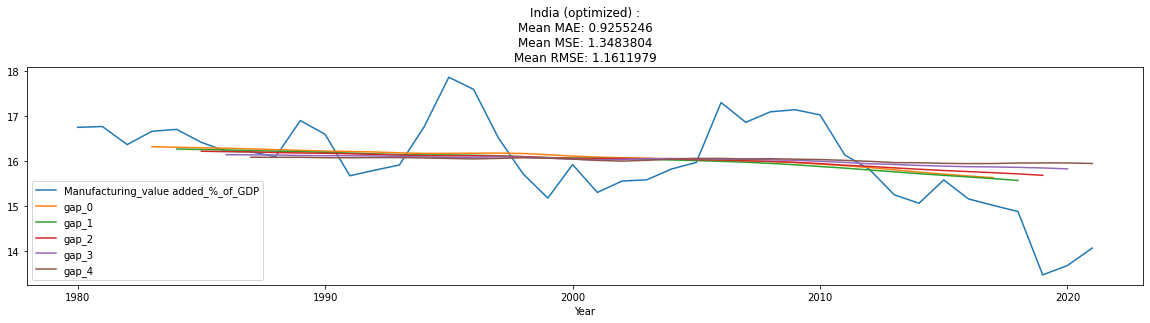

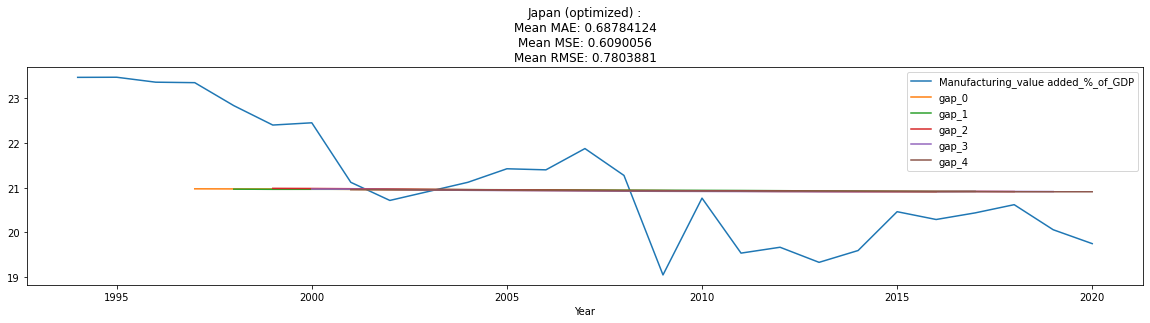

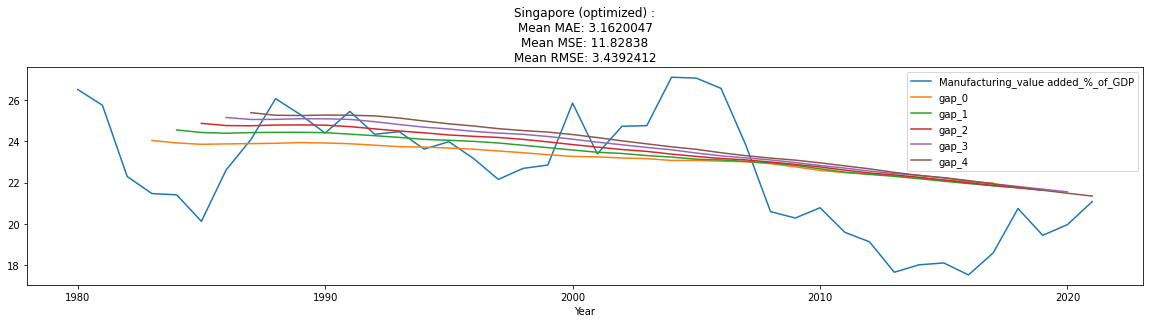

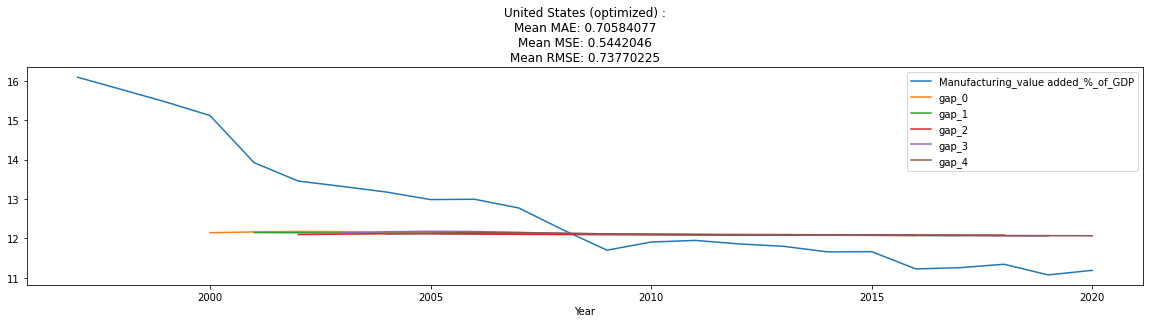

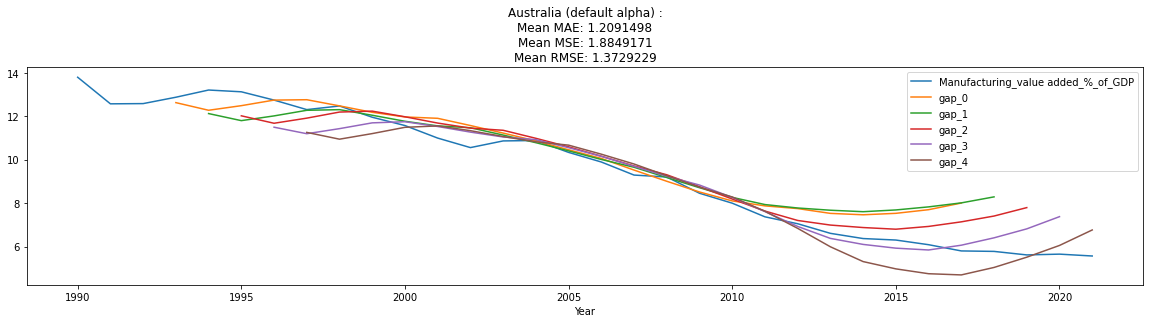

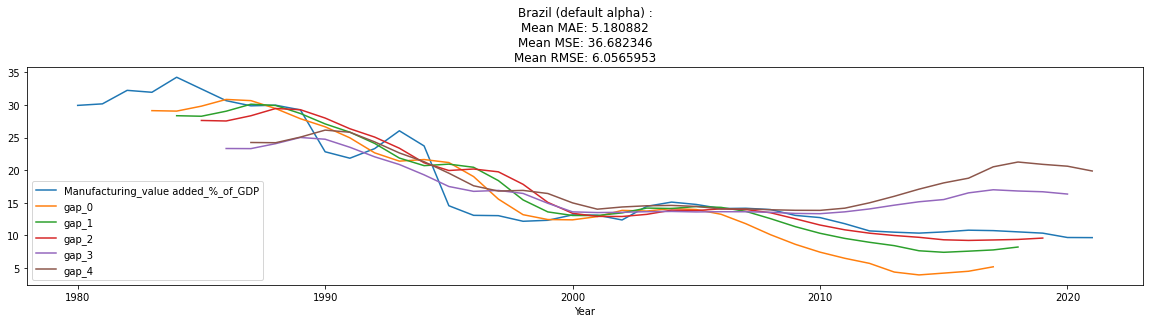

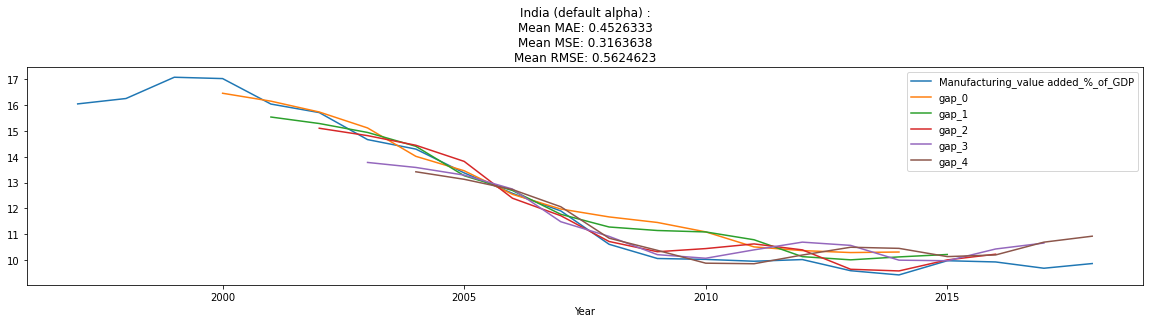

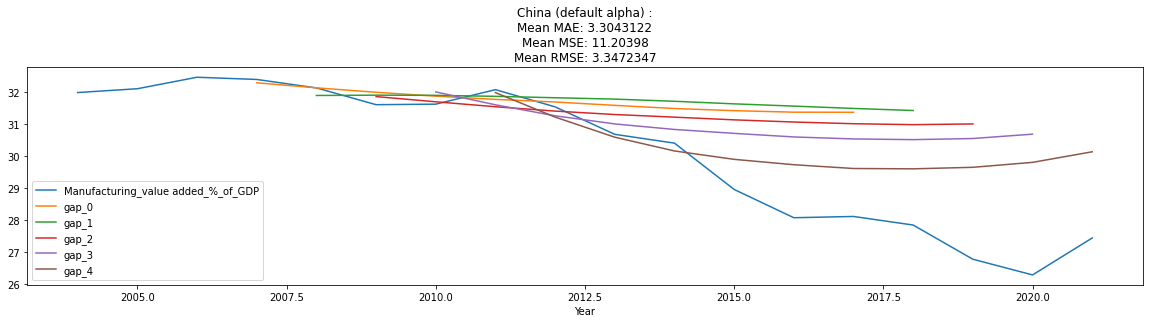

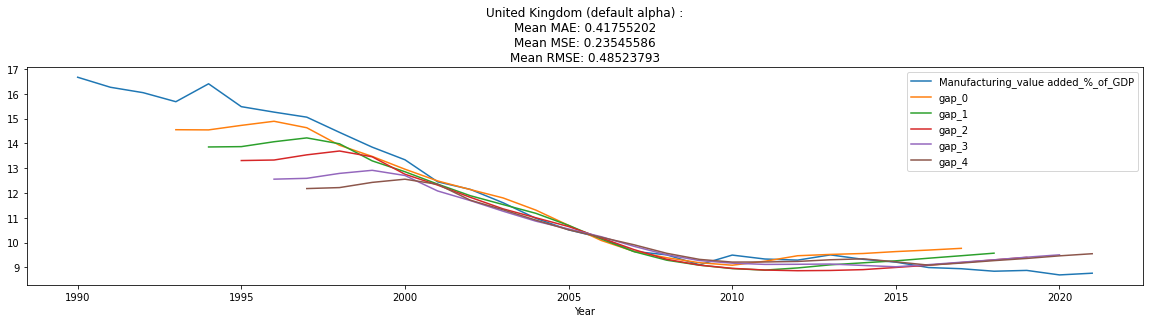

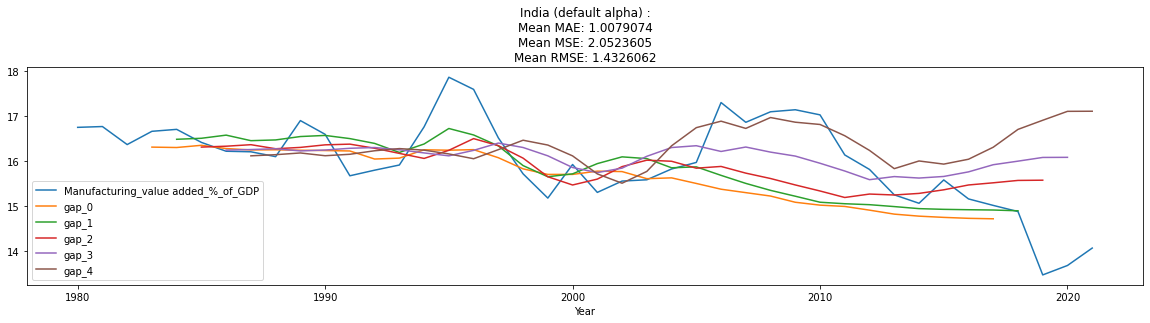

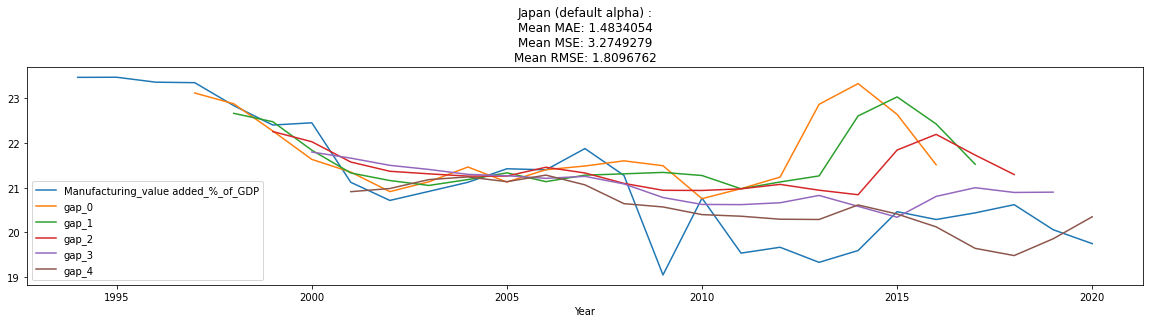

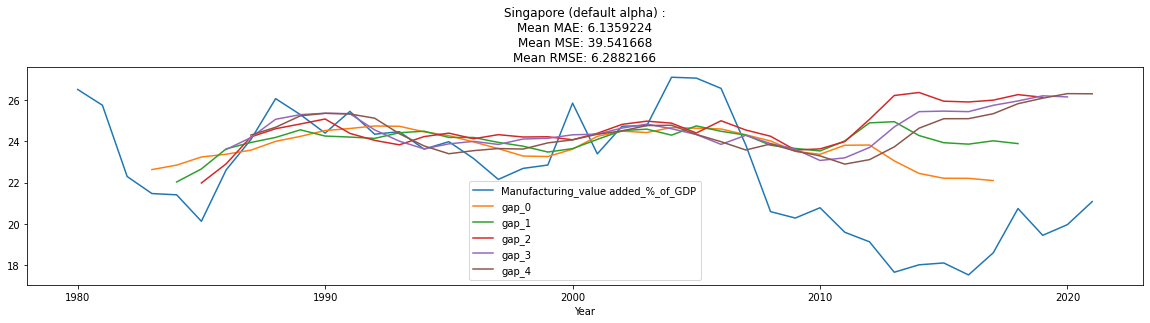

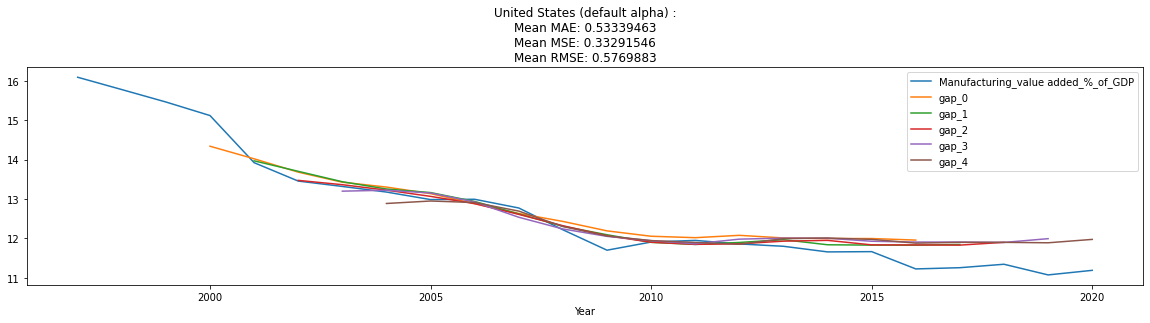

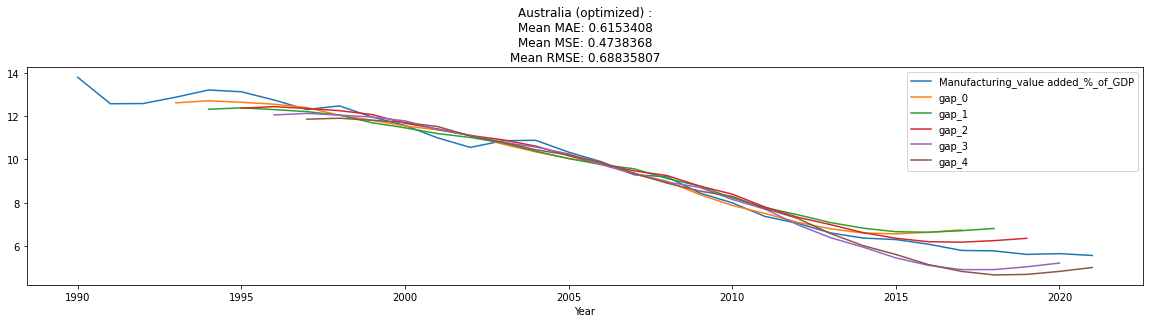

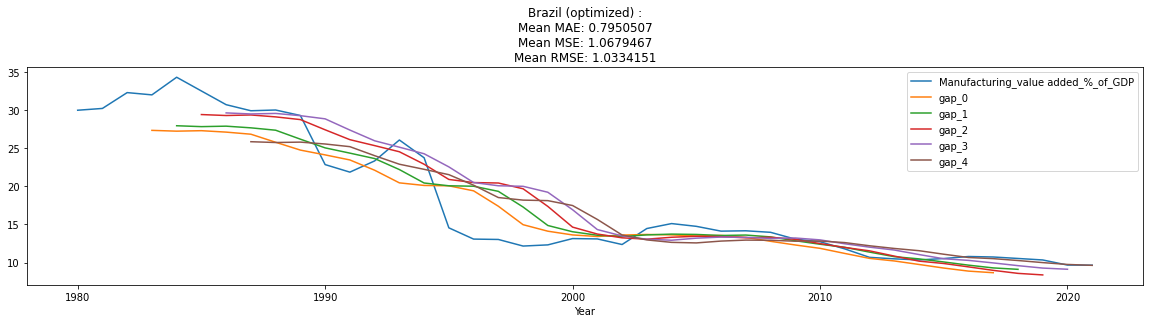

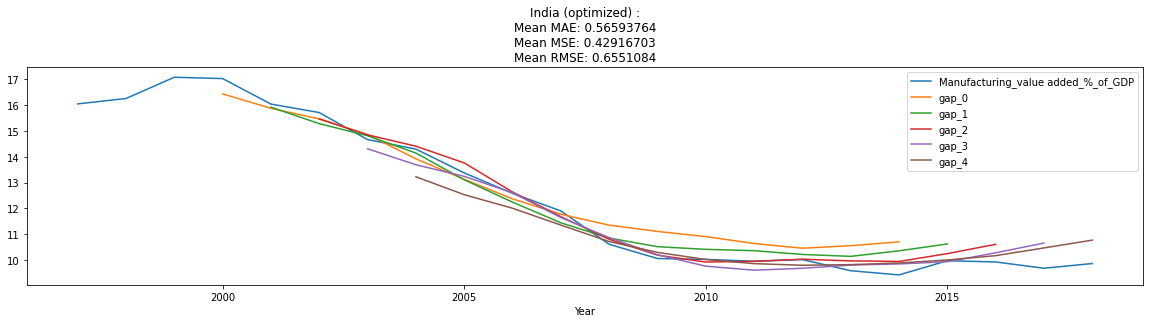

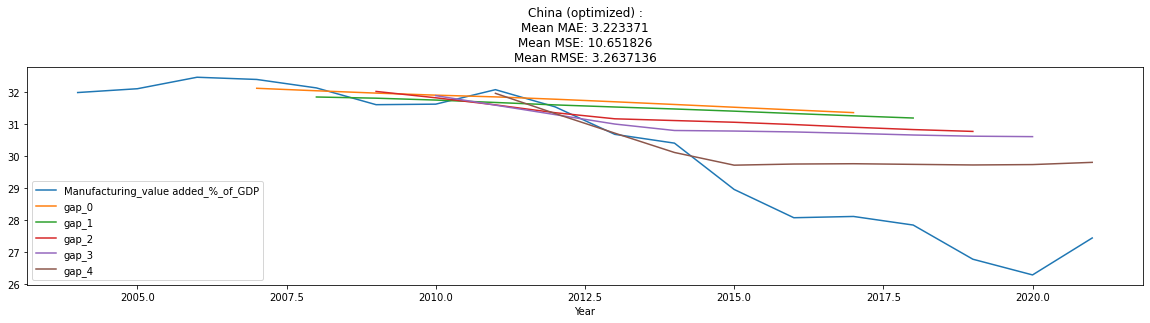

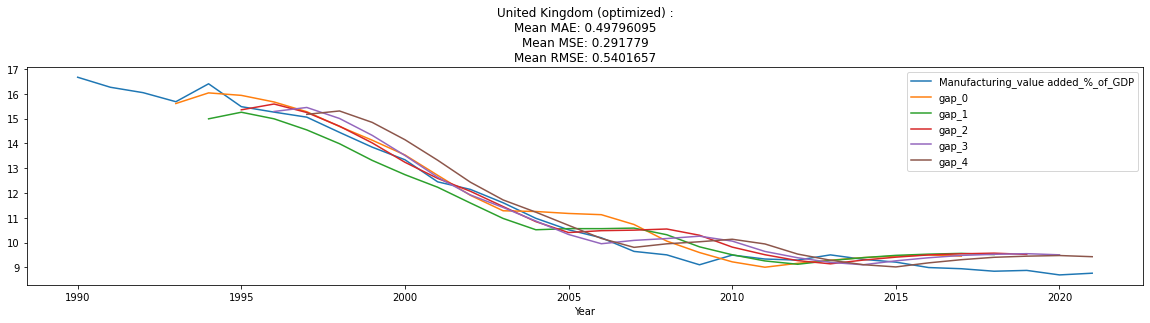

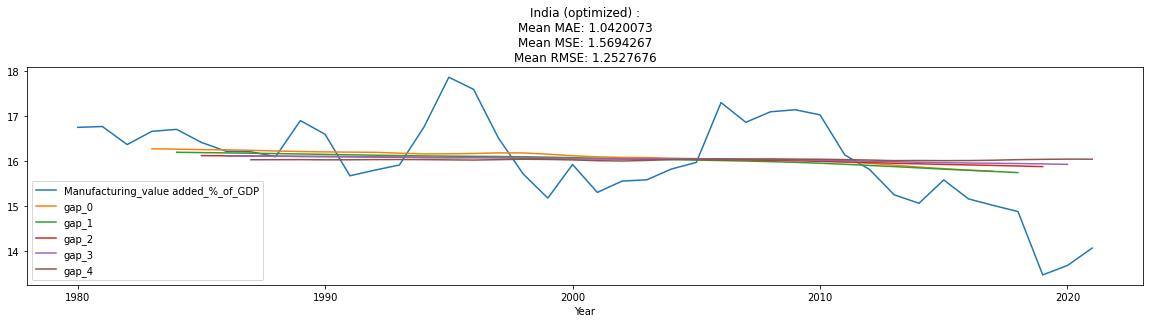

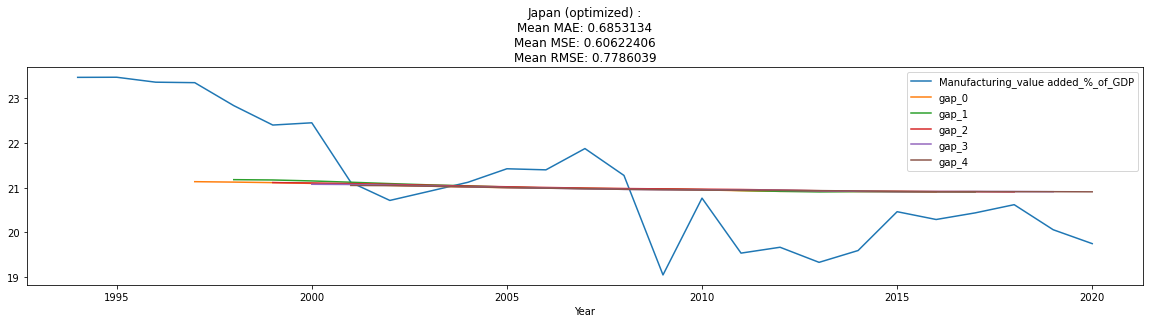

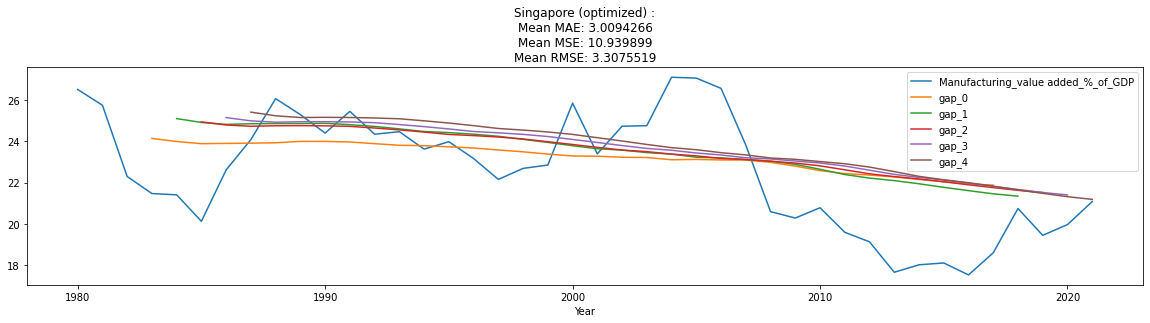

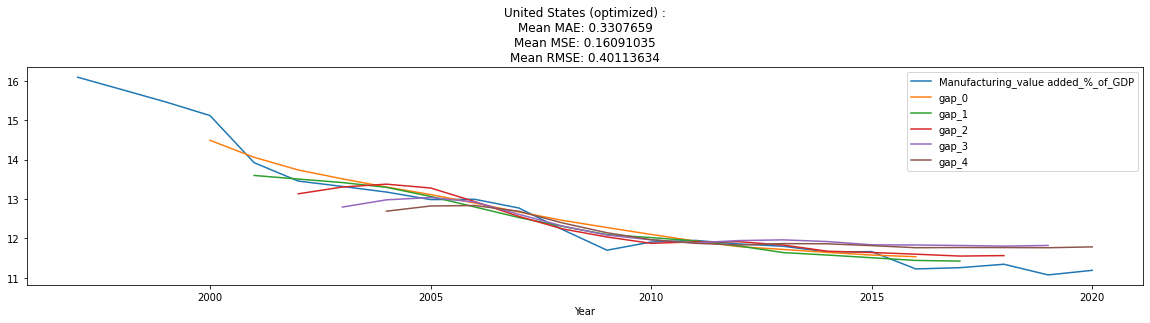

In [43]:
filled=[0,1]
c3, m3, a3, s3, r3,k3 = [], [], [], [], [],[]
c4, m4, a4, s4, r4, k4 = [], [], [], [], [],[]
for k in filled:
  if k ==0:
    SHIFT = 5
    LW = 5
    IW = 3
    MAX_EPOCHS = 50
    bs = 32
    verbose = False
    lr = 0.001
    patience = 50
    LOSS = tf.keras.losses.MeanAbsoluteError()
  elif k==1:
    SHIFT = 5
    LW = 5
    IW = 3
    MAX_EPOCHS = 70
    bs = 46
    verbose = False
    lr = 0.000521
    patience = 22
    LOSS = tf.keras.losses.MeanAbsoluteError()
  for sheet in get_sheet_by_methods(Data_dic_m,k):
    country = sheet[:3]
    method = sheet[3:].strip()
    print(dic_country[country], method, ':')
    a1, s1, r1, val_loss= pipeline(country, method)
    c3.append(country)
    m3.append(method)
    a3.append(a1)
    s3.append(s1)
    r3.append(r1)
    k3.append(val_loss)
    print('\n')
for k in filled:
  if k ==0:
    SHIFT = 5
    LW = 5
    IW = 3
    MAX_EPOCHS = 50
    bs = 32
    verbose = False
    lr = 0.001
    patience = 50
    LOSS = tf.keras.losses.MeanAbsoluteError()
  elif k==1:
    SHIFT = 5
    LW = 5
    IW = 3
    MAX_EPOCHS = 62
    bs = 49
    verbose = False
    lr = 0.001282
    patience = 23
    LOSS = tf.keras.losses.MeanAbsoluteError()
  for sheet in get_sheet_by_methods(Data_dic_s, k):
    country = sheet[:3]
    method = sheet[3:].strip()
    print(dic_country[country], method, ':')
    a1, s1, r1,val_loss= pipeline(country, method)
    c4.append(country)
    m4.append(method)
    a4.append(a1)
    s4.append(s1)
    r4.append(r1)
    k4.append(val_loss)
    print('\n')

In [63]:
print("Manufacturing")
manu_df_result_2=pd.DataFrame({
    'country': c3,
    'method': m3,
    'MAE': a3,
    'MSE': s3,
    'RMSE': r3,
    "val loss": k3
})
print("Mean Performace")
print(manu_df_result_2.groupby("method").mean())
print("\nCountry Performace")
print(manu_df_result_2)

Manufacturing
Mean Performace
                    MAE        MSE      RMSE  val loss
method                                                
default alpha  2.190188  10.706455  2.427066  0.295904
optimized      1.257391   3.100018  1.383029  0.286869

Country Performace
   country         method       MAE        MSE      RMSE  val loss
0      AUS  default alpha  1.349553   2.338439  1.529196  0.067395
1      BRA  default alpha  4.912364  33.919701  5.824062  0.124270
2      CAN  default alpha  0.424626   0.269274  0.518916  0.106664
3      CHN  default alpha  3.278598  11.026730  3.320652  0.396130
4      GBR  default alpha  0.419910   0.239976  0.489874  0.045263
5      IND  default alpha  0.882775   1.543558  1.242400  0.606365
6      JPN  default alpha  1.410292   2.998100  1.731502  0.425778
7      SGP  default alpha  6.501874  43.689152  6.609777  0.784682
8      USA  default alpha  0.531703   0.333173  0.577212  0.106592
9      AUS      optimized  0.505849   0.362443  0.602032  0.

<ipython-input-63-12531213b5c1>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(manu_df_result_2.groupby("method").mean())


In [62]:
print("Servicing\n")
ser_df_result_2=pd.DataFrame({
    'country': c4,
    'method': m4,
    'MAE': a4,
    'MSE': s4,
    'RMSE': r4,
    "val loss": k4
})
print("Mean Performace")
print(ser_df_result_2.groupby("method").mean())
print("\nCountry Performace")
print(ser_df_result_2)

Servicing

Mean Performace
                    MAE        MSE      RMSE  val loss
method                                                
default alpha  2.191684  10.613881  2.436882  0.294548
optimized      1.196130   2.910113  1.324536  0.302517

Country Performace
   country         method       MAE        MSE      RMSE  val loss
0      AUS  default alpha  1.209150   1.884917  1.372923  0.076986
1      BRA  default alpha  5.180882  36.682346  6.056595  0.121161
2      CAN  default alpha  0.452633   0.316364  0.562462  0.097817
3      CHN  default alpha  3.304312  11.203980  3.347235  0.402027
4      GBR  default alpha  0.417552   0.235456  0.485238  0.037546
5      IND  default alpha  1.007907   2.052361  1.432606  0.611982
6      JPN  default alpha  1.483405   3.274928  1.809676  0.427167
7      SGP  default alpha  6.135922  39.541668  6.288217  0.768665
8      USA  default alpha  0.533395   0.332915  0.576988  0.107581
9      AUS      optimized  0.615341   0.473837  0.688358  0.111

<ipython-input-62-2fd8574c5085>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(ser_df_result_2.groupby("method").mean())
